Phase 1 :

In [1]:
# == imports ==
import os
from glob import glob
import cv2
import numpy as np
import pandas as pd
from skimage import measure
from tqdm import tqdm
import matplotlib.pyplot as plt

# Display settings (optional)
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)


In [2]:
def read_image(path, resize = None):
    img = cv2.imread(path)
    if img is None:
        raise ValueError(f"Can't read {path}")
    if resize is not None:
        img = cv2.resize(img, resize)
        
    return img


def segment_fruit_rgb(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    
    mask = (s > 30) & (v > 30)
    mask = mask.astype('uint8') * 255
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    
    contours, __ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return mask
    c = max(contours, key = cv2.contourArea)
    main_mask = np.zeros_like(mask)
    cv2.drawContours(main_mask, [c], -1, 255, -1)
    return main_mask

def extract_features_from_image(img, mask):
    mask_bool = mask.astype(bool)
    area = mask_bool.sum()
    ys, xs = np.where(mask_bool)

    if area == 0 or len(xs) == 0 or len(ys) == 0:
        return {
            'area': 0, 'perimeter': 0, 'circularity': 0,
            'mean_h': np.nan, 'mean_s': np.nan, 'mean_v': np.nan,
            'std_h': np.nan, 'std_s': np.nan, 'std_v': np.nan,
            'dark_ratio': np.nan, 'blemish_ratio': np.nan,
            'bbox_area': np.nan
        }
        
    h_img, w_img = mask.shape
    minx, maxx = np.clip(xs.min(), 0, w_img - 1), np.clip(xs.max(), 0, w_img - 1)
    miny, maxy = np.clip(ys.min(), 0, h_img - 1), np.clip(ys.max(), 0, h_img - 1)

    bbox_area = (maxx - minx + 1) * (maxy - miny + 1)

    contours, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    perim = cv2.arcLength(contours[0], True) if contours else 0
    circularity = (4 * np.pi * area / (perim**2)) if perim > 0 else 0

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = hsv[:,:,0], hsv[:,:,1], hsv[:,:,2]
    mean_h, mean_s, mean_v = h[mask_bool].mean(), s[mask_bool].mean(), v[mask_bool].mean()
    std_h, std_s, std_v = h[mask_bool].std(), s[mask_bool].std(), v[mask_bool].std()
    dark_ratio = (v[mask_bool] < 50).sum() / area

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    fruit_gray = gray[miny:maxy+1, minx:maxx+1]
    _, th = cv2.threshold(fruit_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    blemish_mask = (fruit_gray < (th.mean())).astype(np.uint8) * 255
    blemish_ratio = (blemish_mask > 0).sum() / (fruit_gray.size + 1e-9)

    return {
        'area': int(area),
        'perimeter': float(perim),
        'circularity': float(circularity),
        'mean_h': float(mean_h), 'mean_s': float(mean_s), 'mean_v': float(mean_v),
        'std_h': float(std_h), 'std_s': float(std_s), 'std_v': float(std_v),
        'dark_ratio': float(dark_ratio),
        'blemish_ratio': float(blemish_ratio),
        'bbox_area': int(bbox_area)
    }


In [3]:
base_dir = "../data/Fruit-Images-Dataset/Training/"
if not os.path.exists(base_dir):
    print("Dataset not found. Please download it first (see README.md).")
else:
    print("Dataset found at:", base_dir)

rows = []

classes = sorted(os.listdir(base_dir))

for cls in classes:
    paths = glob(os.path.join(base_dir, cls, "*.jpg"))
    
    for p in tqdm(paths, desc=f"Processing {cls}", leave=False):
        try:
            img = read_image(p, resize=(200,200))
            mask = segment_fruit_rgb(img)
            feats = extract_features_from_image(img, mask)
            feats.update({'path': p, 'class': cls})
            rows.append(feats)
        except Exception as e:
            print("Error:", p, e)

df = pd.DataFrame(rows)
print("Extracted features for", len(df), "images")
df.head()


Dataset found at: ../data/Fruit-Images-Dataset/Training/


Extracted features for 67692 images


,area,perimeter,circularity,mean_h,mean_s,mean_v,std_h,std_s,std_v,dark_ratio,blemish_ratio,bbox_area,path,class
0,25849,674.499563,0.713987,7.306472,193.098224,142.264846,15.617579,46.797675,59.179517,0.088050,0.538419,34020,../data/Fruit-Images-Dataset/Training/Apple Br...,Apple Braeburn
1,26837,695.085348,0.698020,7.364273,202.479152,119.909975,30.767463,45.872229,46.223669,0.092894,0.377049,34038,../data/Fruit-Images-Dataset/Training/Apple Br...,Apple Braeburn
2,26718,703.813270,0.677796,9.230930,202.014747,120.254884,35.452176,45.935361,46.037668,0.090389,0.379734,34224,../data/Fruit-Images-Dataset/Training/Apple Br...,Apple Braeburn
3,26725,716.298551,0.654545,8.220393,202.446997,119.750084,32.819261,45.815294,46.138453,0.094256,0.399135,35156,../data/Fruit-Images-Dataset/Training/Apple Br...,Apple Braeburn
4,26758,711.126977,0.664920,8.009418,202.488153,119.646311,32.355447,45.518584,46.253085,0.094888,0.400102,35156,../data/Fruit-Images-Dataset/Training/Apple Br...,Apple Braeburn


Phase 2:

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
print("Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())

df.describe()


Shape: (67692, 14)

Columns:
 ['area', 'perimeter', 'circularity', 'mean_h', 'mean_s', 'mean_v', 'std_h', 'std_s', 'std_v', 'dark_ratio', 'blemish_ratio', 'bbox_area', 'path', 'class']


,area,perimeter,circularity,mean_h,mean_s,mean_v,std_h,std_s,std_v,dark_ratio,blemish_ratio,bbox_area
count,67692.000000,67692.000000,67692.000000,67692.000000,67692.000000,67692.000000,67692.000000,67692.000000,67692.000000,67692.000000,67692.000000,67692.000000
mean,23516.128110,648.223198,0.716652,45.791393,144.636555,134.042336,25.880122,39.909905,35.670603,0.074311,0.254633,32187.344960
std,6703.238995,107.501826,0.189900,44.622542,49.930942,44.621964,27.186182,12.532861,10.378250,0.139584,0.212335,7237.782827
min,129.000000,43.556349,0.052188,3.180911,29.269461,33.932088,0.946319,4.059726,3.917720,0.000000,0.000000,180.000000
25%,19641.000000,602.658942,0.646532,16.084064,106.424232,101.490705,4.833695,32.280165,28.815984,0.000000,0.051270,28756.000000
50%,25315.500000,645.126978,0.791768,24.180262,147.016511,131.621974,12.339513,41.086252,35.646272,0.005965,0.223887,34200.000000
75%,28728.250000,674.321892,0.856282,57.351734,186.326389,166.428511,42.790920,47.613780,42.463998,0.082136,0.417471,37400.000000
max,33889.000000,1605.474298,0.905822,175.442121,232.412205,241.267603,88.596671,84.125249,73.109543,1.000000,1.000000,40000.000000


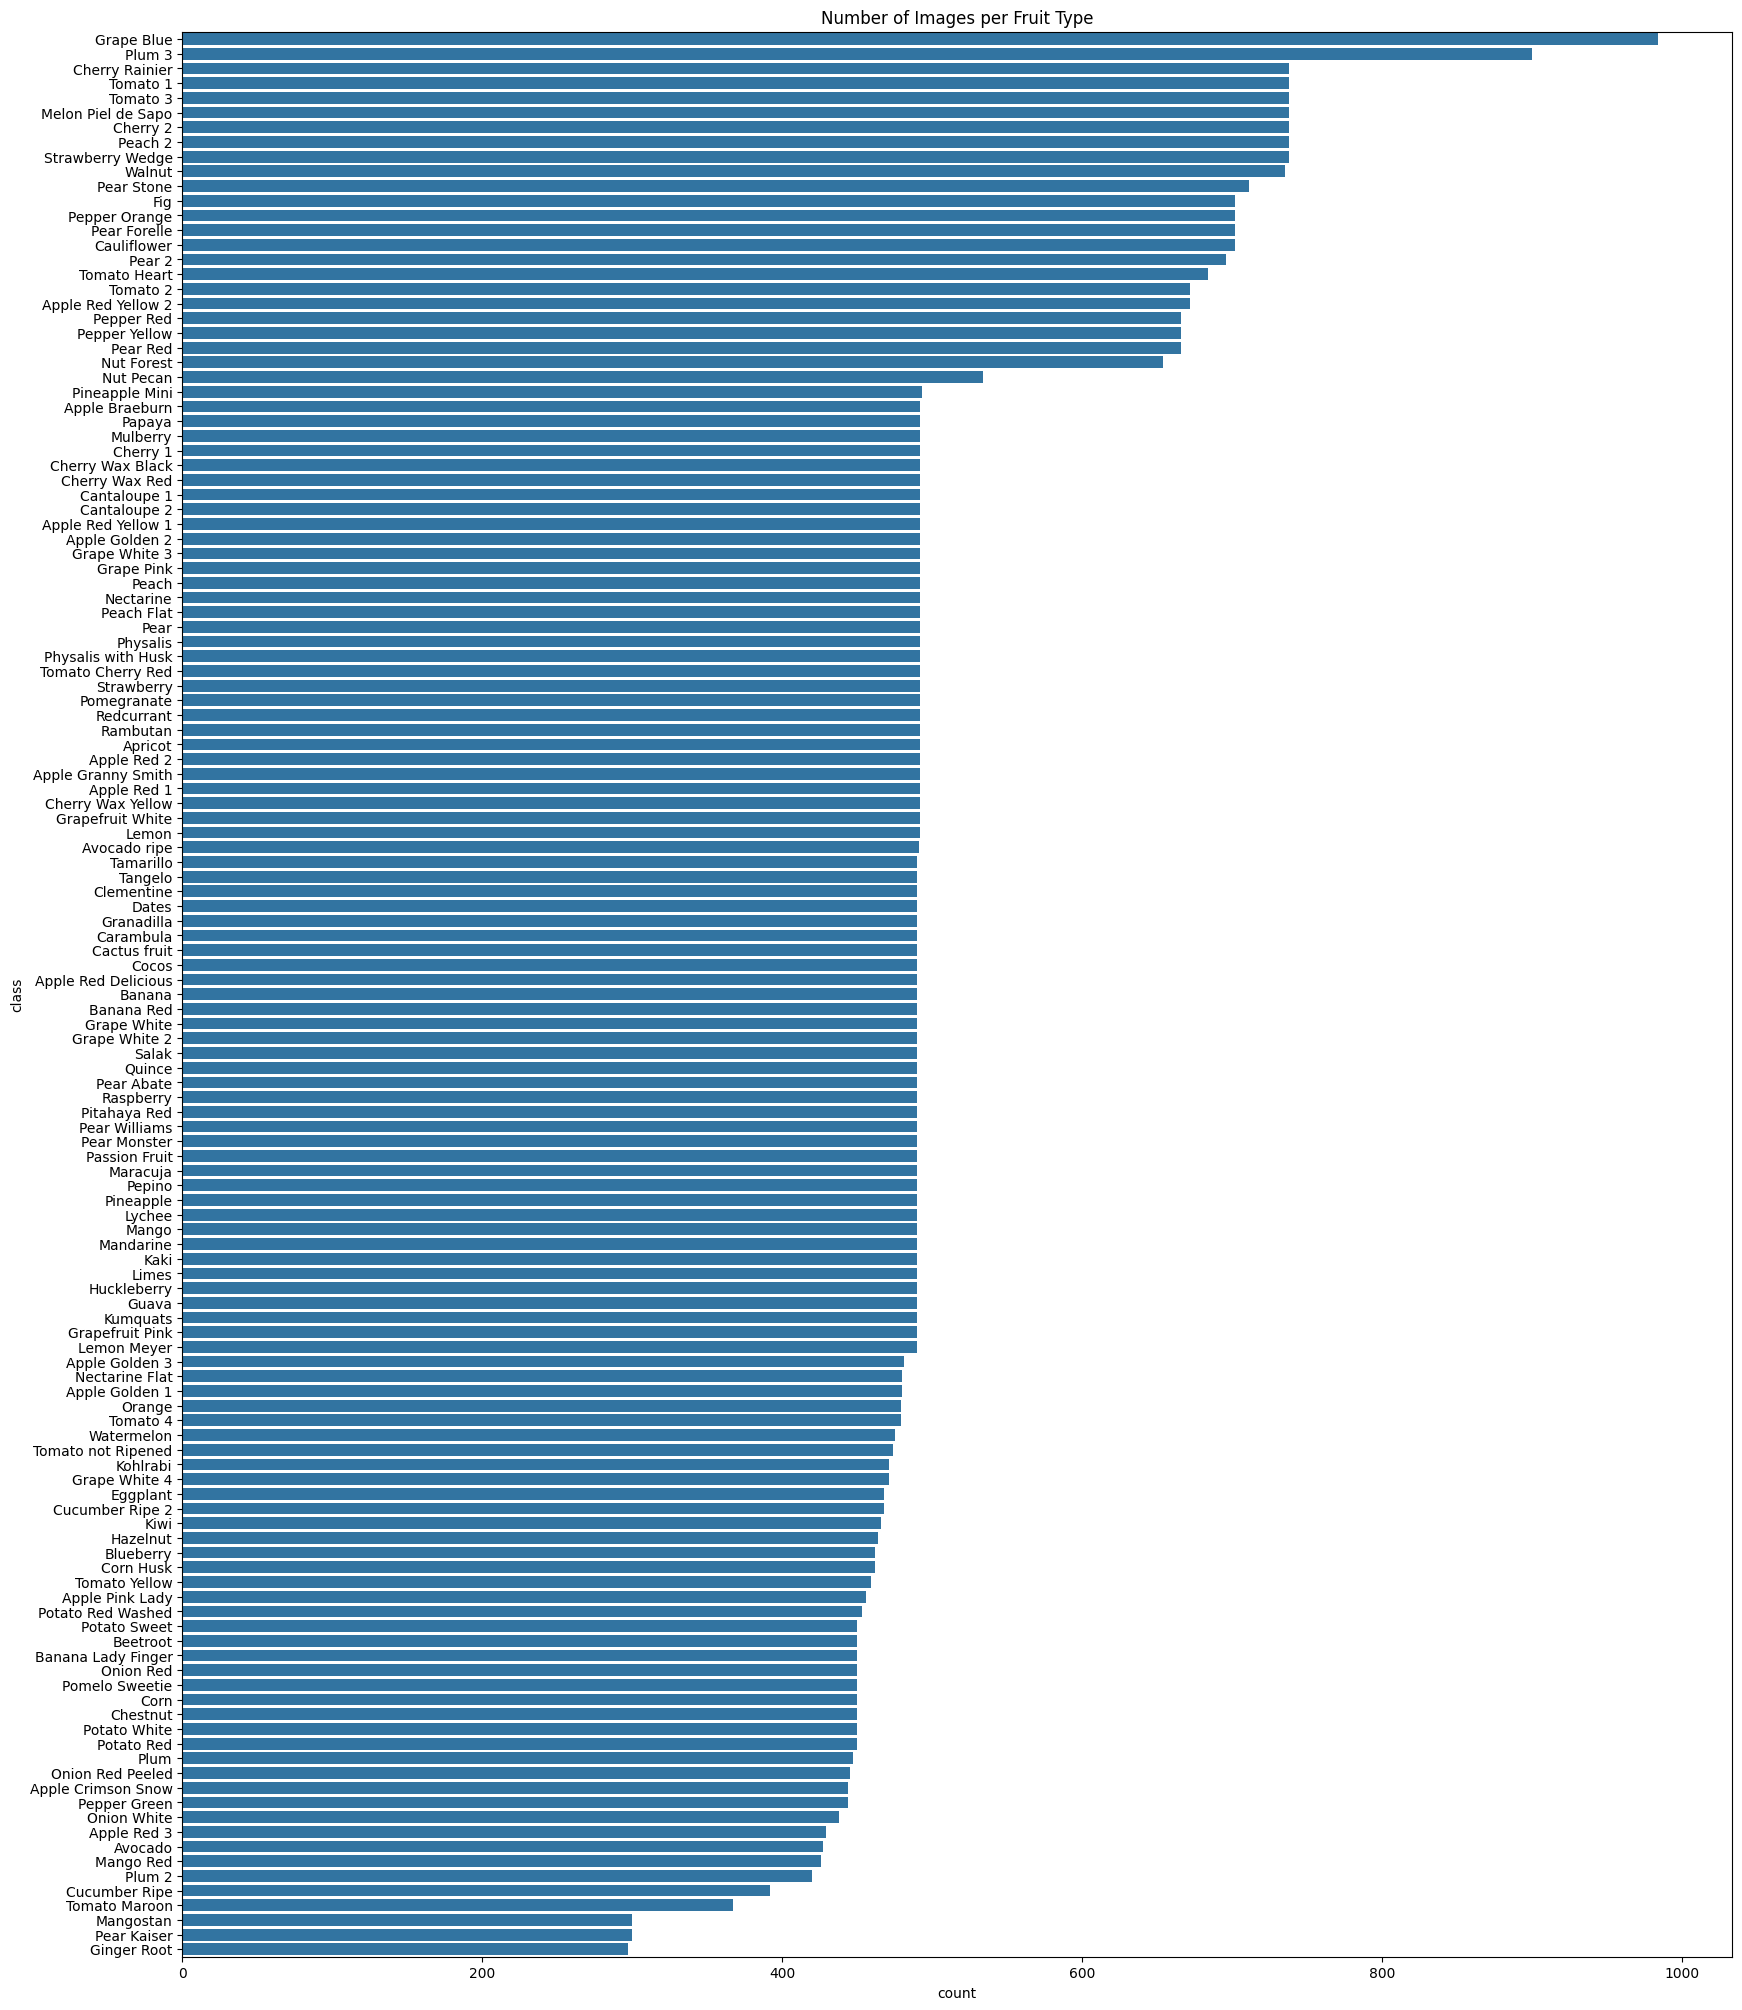

In [6]:
plt.figure(figsize=(20,25))
sns.countplot(y="class", data=df, order=df['class'].value_counts().index)
plt.title("Number of Images per Fruit Type")
plt.show()


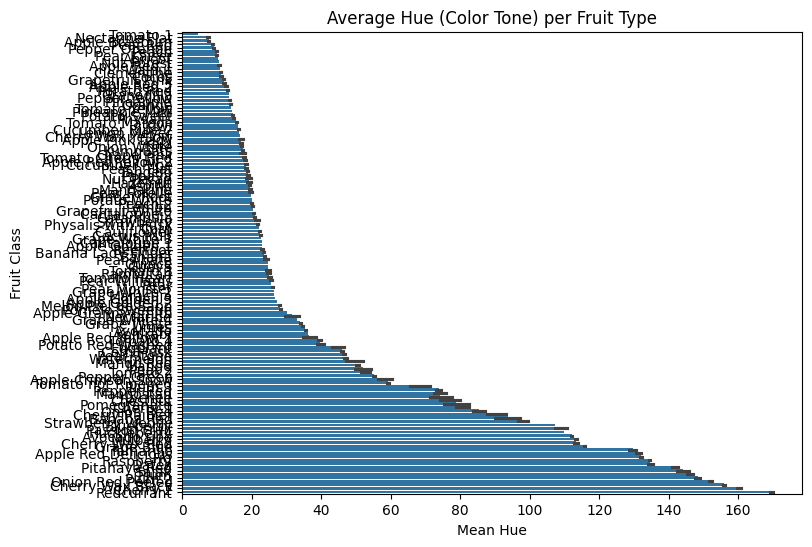

In [7]:
plt.Figure(figsize=(15, 30))
sns.barplot(data=df, x="mean_h", y="class", order=df.groupby('class')["mean_h"].mean().sort_values().index)
plt.title("Average Hue (Color Tone) per Fruit Type")
plt.xlabel("Mean Hue")
plt.ylabel("Fruit Class")
plt.show()

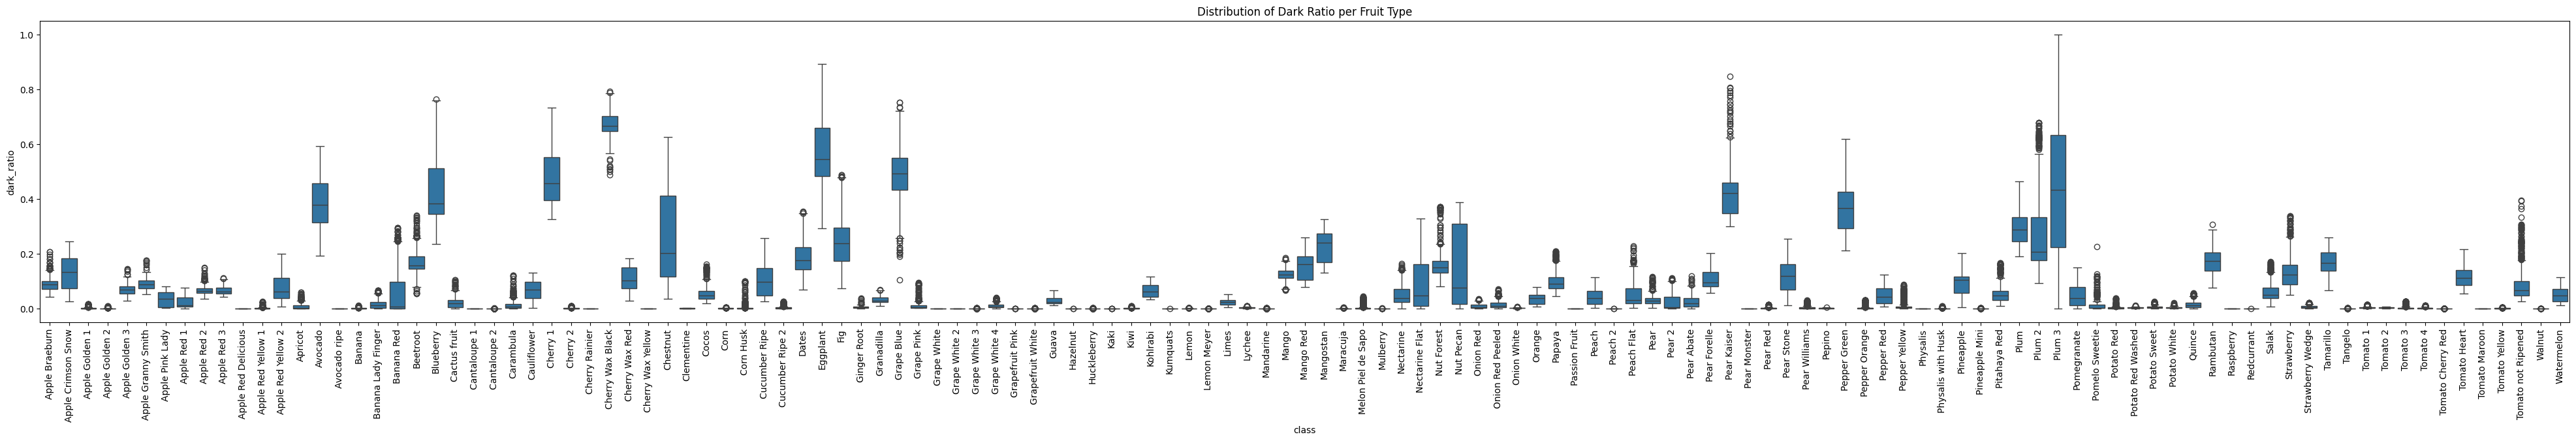

In [8]:
plt.figure(figsize=(50,6))
sns.boxplot(data=df, x="class", y="dark_ratio")
plt.xticks(rotation=90)
plt.title("Distribution of Dark Ratio per Fruit Type")
plt.show()

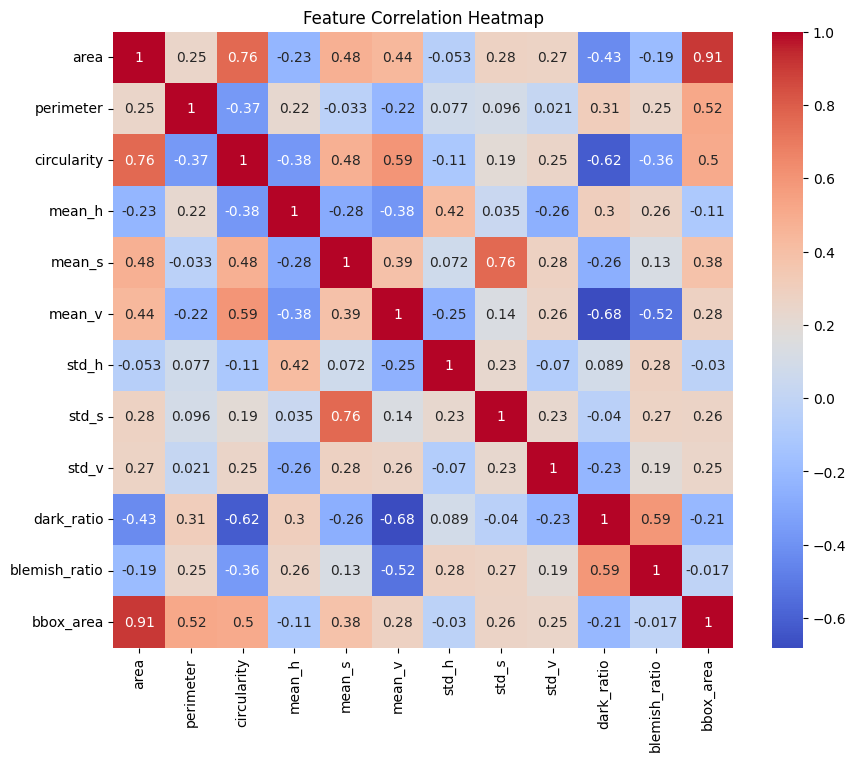

In [9]:
plt.figure(figsize=(10,8))
sns.heatmap(df.drop(columns=['path', 'class']).corr(), cmap='coolwarm', annot=True)
plt.title("Feature Correlation Heatmap")
plt.show()

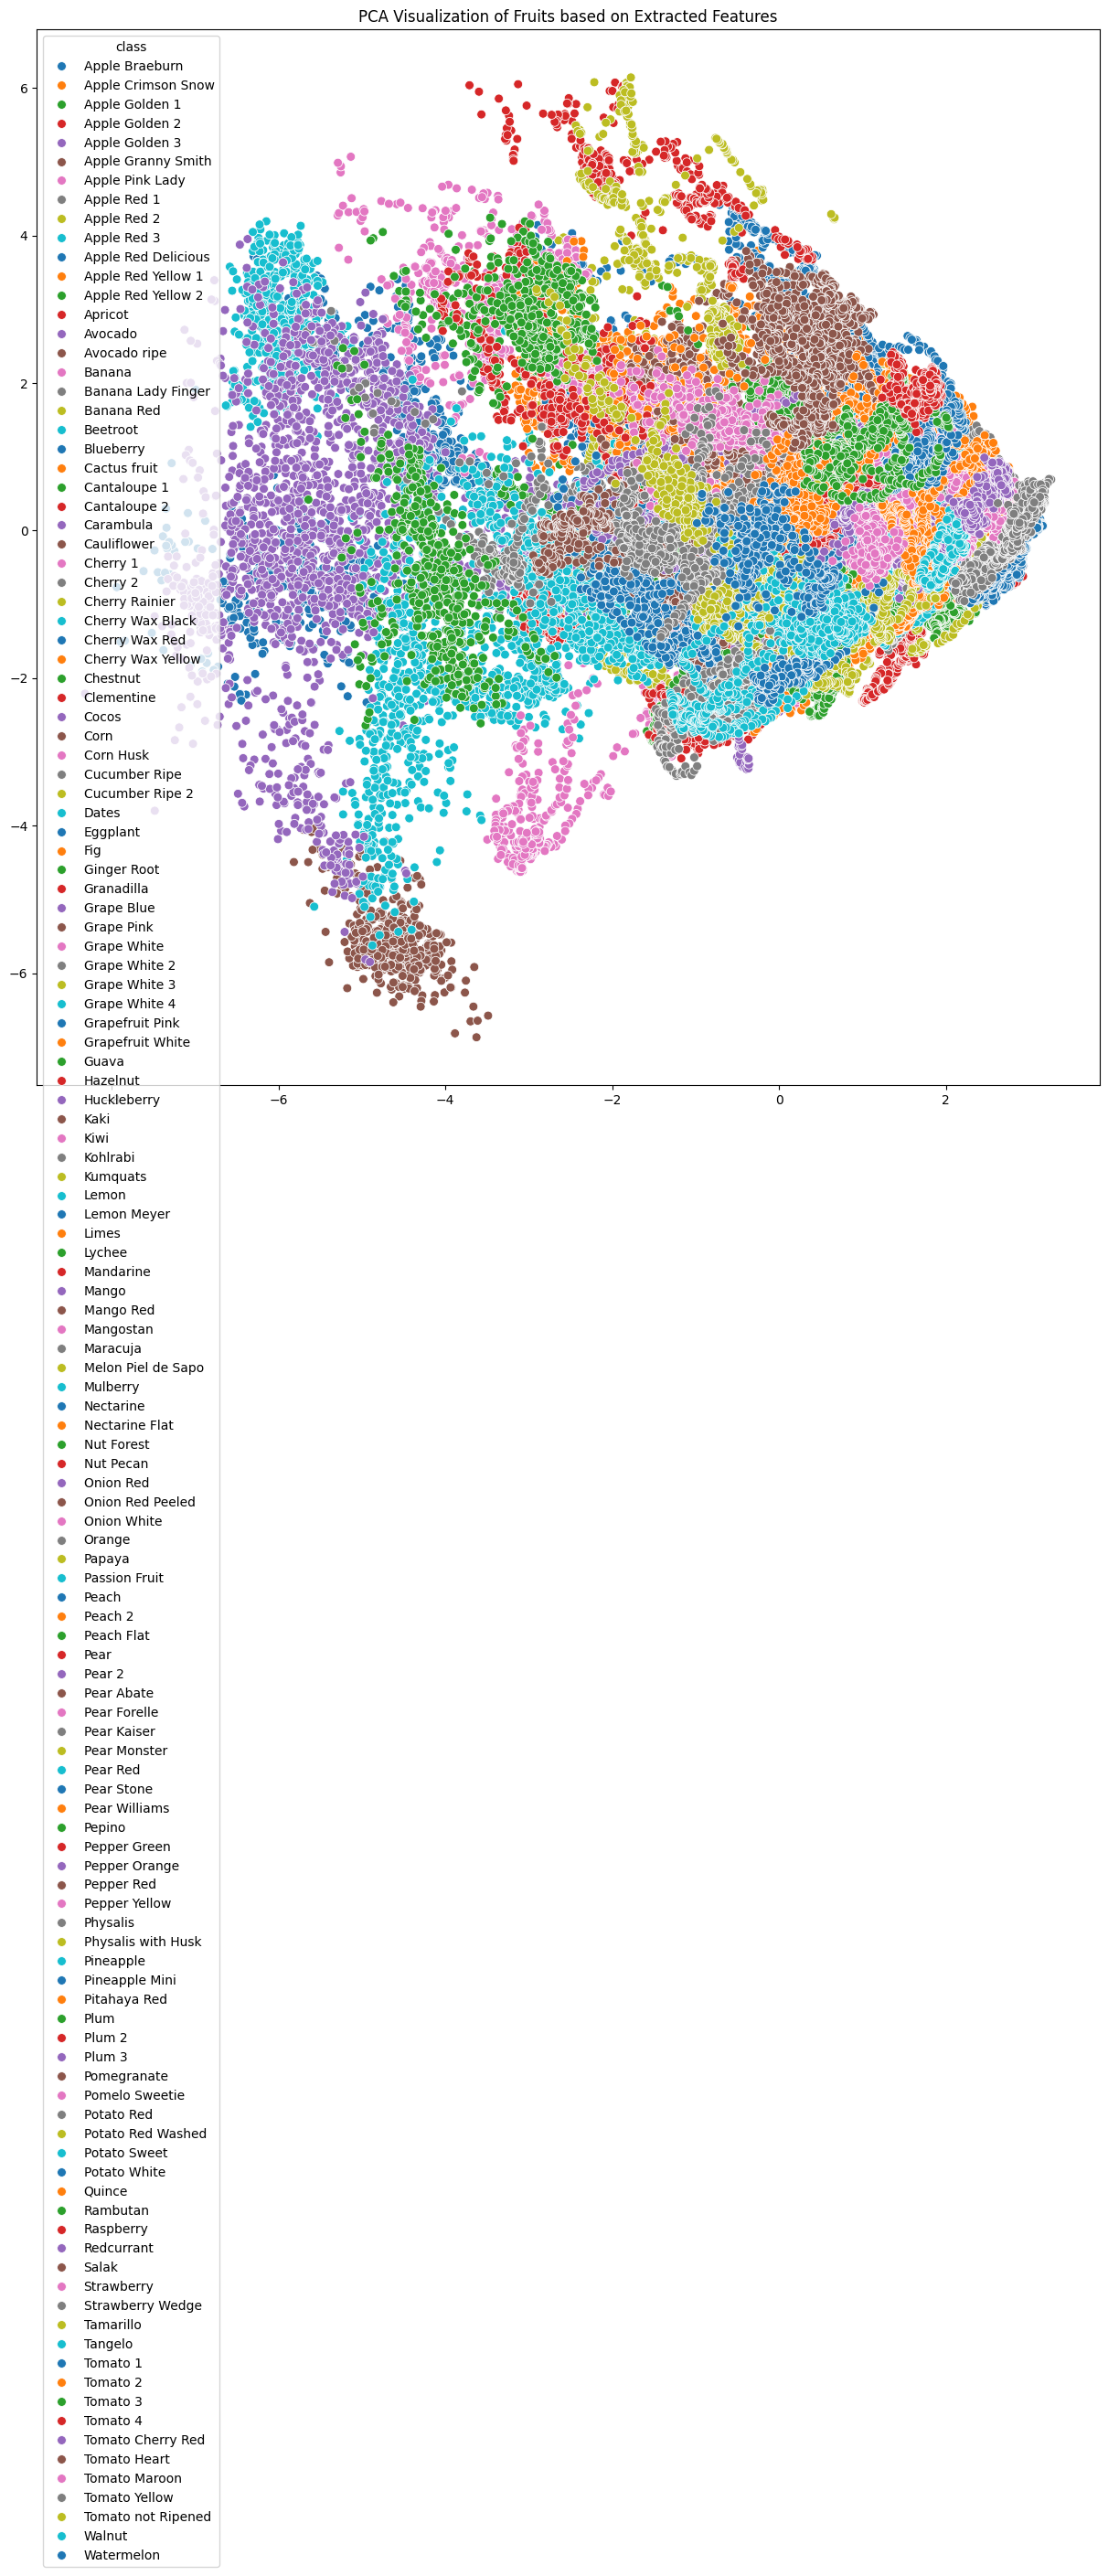

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=['path','class'])
X = X.fillna(0)
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(15,15))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['class'], palette="tab10", s=50)
plt.title("PCA Visualization of Fruits based on Extracted Features")
plt.show()

Phase 3 :

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
test_dir = "../data/Fruit-Images-Dataset/Test/"

def build_feature_df(base_dir):
    rows = []
    classes = sorted(os.listdir(base_dir))
    for cls in classes:
        paths = glob(os.path.join(base_dir, cls, "*.jpg"))
        for p in tqdm(paths, desc=f"Processing {cls}", leave=False):
            try:
                img = read_image(p, resize=(200,200))
                mask = segment_fruit_rgb(img)
                feats = extract_features_from_image(img, mask)
                feats.update({'path': p, 'class': cls})
                rows.append(feats)
            except Exception as e:
                print("Error", p, e)
    return pd.DataFrame(rows)
df_test = build_feature_df(test_dir)

In [13]:
X_train = df.drop(columns=['path', 'class']).fillna(0)
y_train = df['class']


X_test = df_test.drop(columns=['path', 'class']).fillna(0)
y_test = df_test['class']


le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_scaled, y_train_encoded)

y_pred = rf.predict(X_test_scaled)

In [14]:
y_pred_labels = le.inverse_transform(y_pred)


acc = accuracy_score(y_test, y_pred_labels)
print("Accuracy:", round(acc*100, 2), "%\n")


print("Classification Report:")
print(classification_report(y_test, y_pred_labels, target_names=le.classes_))

Accuracy: 97.36 %

Classification Report:
                     precision    recall  f1-score   support

     Apple Braeburn       0.93      0.86      0.89       164
 Apple Crimson Snow       0.95      0.73      0.82       148
     Apple Golden 1       1.00      1.00      1.00       160
     Apple Golden 2       1.00      1.00      1.00       164
     Apple Golden 3       1.00      1.00      1.00       161
 Apple Granny Smith       1.00      1.00      1.00       164
    Apple Pink Lady       0.75      0.91      0.82       152
        Apple Red 1       0.88      0.95      0.91       164
        Apple Red 2       0.85      1.00      0.92       164
        Apple Red 3       0.95      1.00      0.97       144
Apple Red Delicious       1.00      1.00      1.00       166
 Apple Red Yellow 1       0.97      0.81      0.88       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       1.00      1.00      1.00       164
            Avocado       1.00      1.00  

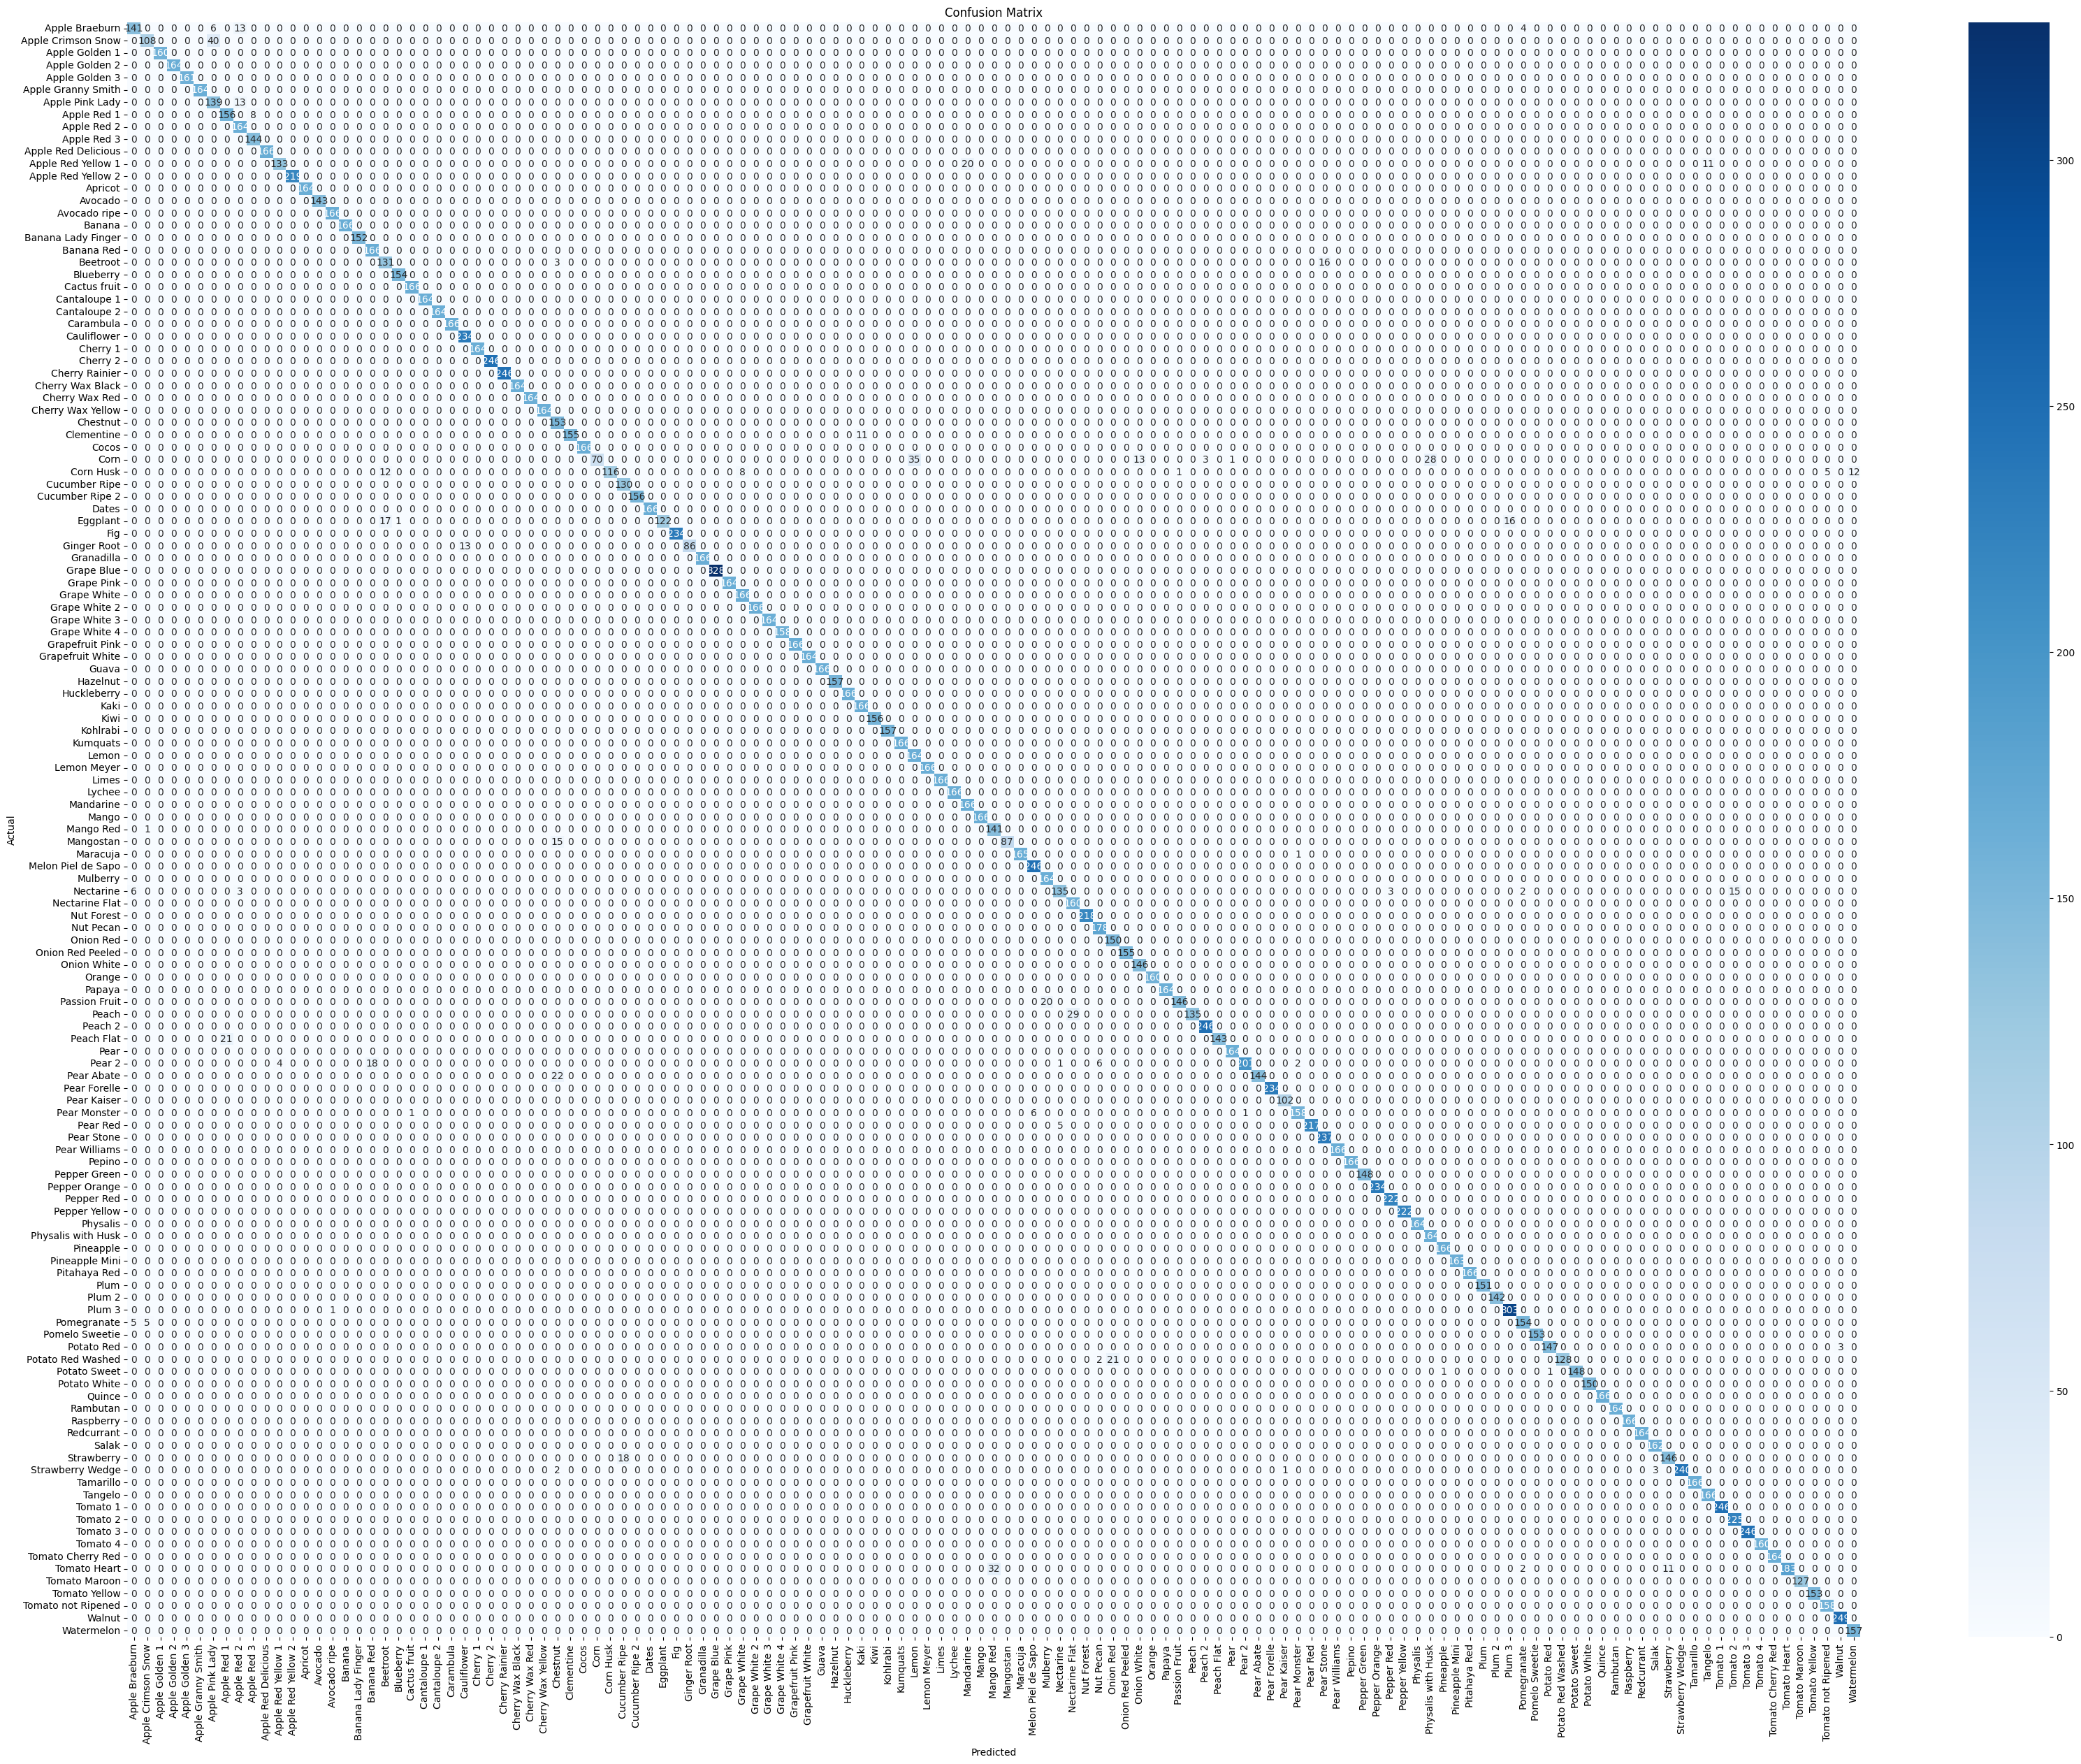

In [15]:
cm = confusion_matrix(y_test, y_pred_labels, labels=le.classes_)

plt.figure(figsize=(40,30))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

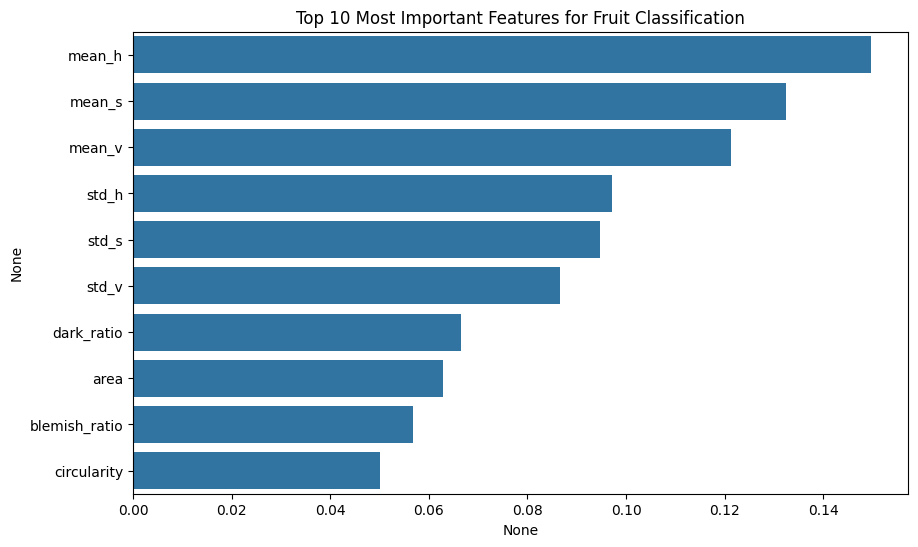

In [16]:
feat_imp = pd.Series(rf.feature_importances_, index=X.columns)
feat_imp = feat_imp.sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp[:10], y=feat_imp.index[:10])
plt.title("Top 10 Most Important Features for Fruit Classification")
plt.show()